# Optimizing the k-means Clustering model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import tensorflow_hub as hub

plt.rcParams['figure.figsize']=(8.0, 6.0)
%config InlineBackend.figure_format='retina'



[Link to download USE from TensorFlow Hub local source](https://tfhub.dev/google/universal-sentence-encoder/4)




In [2]:
# Loads Universal Sentence Encoder from TensorFlow Hub online source
#embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

# Loads Universal Sentence Encoder from TensorFlow Hub local source

embed = hub.load("/Users/data/universal-sentence-encoder_4")


## The Direction

Our main goal here is to find the <b>`different perspectives of the users`</b> and their experiences about the products from the review contents. With the help of k-means clustering, we can quickly locate the regions of the clusters which are the different perspectives of the users.

We have already filtered out all the reviews with less than 6 words to eliminate all the non-meaningful factors which decrease the total amount from around 300 reviews to roughly 180 reviews. However, from the `02_Modelling_for_GoodVitamins`, we have gathered pretty good amount of the main themes through the review contents. In this scenerio, ,<b>we should adjust the algorithm to work well with the small set of reviews</b>. 

With k-means clustering, after vectorizing all the text data into 512-dimensional space, we can identify the cluster centres, and then find the reviews which are closet to these centres. However, we have to be mindful because we only have a small set of reviews. <b>We shouldn't increase the range of the cluster centers too high because it will make the reviews of one cluster overlap with other clusters which means we may have the same reviews in both clusters</b>. In our situation, the range of cluster means the numbers of reviews data point we want to have around the cluster centres.

Secondly, we should find the optimal k value to fit with the amount of reviews content that we currently have. We couldn't have 10 to 15 clusters with the small set of reviews because there will be similar patterns in all the clusters. Therefore, we will keep the `k values from 2 to 5 and see which value will give more insights`.

Furthermore, we should consider whether filtering reviews by the individual user rating could deliver more meaningful or less meaningful because all of the products that we scrapped are the bestselling products. 
In the bestselling section, all the products have around `81% reviews` with 5 stars, `11% reviews` wit 4 stars and there are `very small percentage` of 3, 2, and 1 stars reviews. It could be some biased which iHerbs could have been filtering out many negative reviews and keeping only positive reviews. Therefore, we may not derive much meaningful values from negative reviews. Additionally, if the negative reviews are less than 6 words, they will be filterd out as well.

### Cluster Exploration

We will be working with the same example from `02_Modelling_for_GoodVitamins` : <b>`Vitamin D3 + K2, Soy-Free, 125 mcg (5000 IU), 60 VegCaps`</b> .

<img src = "https://docs.google.com/uc?export=download&id=1xFdWjxVs0vjFNeQgKzVifSHUHQhqY6N_" />



In [3]:
def load_reviews(df_path, product_name):
    '''
    Function to load and embed review content
    '''
    
    # Read in processed file as dataframe
    df = pd.read_csv(df_path)

    # Copy sentence column to new variable
    product_review = df['review_contents'].loc[df['item_name'] == product_name].reset_index(drop=True).copy()

    # Check the numbers of the review
    n = product_review.shape[0]
    
    # Vectorize sentences
    review_vectors = embed(product_review)
    
    return product_review, review_vectors, n

In [4]:
def get_scores(review_vectors, k_min=2, k_max=7):
    '''
    Function to check inertia and silhouette scores for a range from 2 to 7 of k values
    '''

    # Set range of k values to loop through
    kv = range(k_min, k_max + 1)

    # Initialize lists to store inertia scores and silhouette scores
    inertia_scores = []
    sil_scores = []

    # Loop through values of k
    for k in kv:

        # Instantiate the model
        kmeans_model = KMeans(n_clusters=k, random_state=10)

        # Fit the model
        kmeans_model.fit(review_vectors)

        # Append the model's inertia score to master list
        inertia_scores.append(kmeans_model.inertia_)

        # Append the model's silhouette score to master list
        labels = kmeans_model.labels_
        sil_score = silhouette_score(review_vectors, labels)
        sil_scores.append(sil_score)
        
    return inertia_scores, sil_scores, kv

In [5]:
product_review, review_vectors, n = load_reviews('/Users/data/iherb_best_selling_products_clean_dataset.csv','Vitamin D3 + K2, Soy-Free, 125 mcg (5000 IU), 60 VegCaps')

In [6]:
# Check the numbers of review content:
print(n)

142


In [7]:
inertia_scores, sil_scores, kv = get_scores(review_vectors)

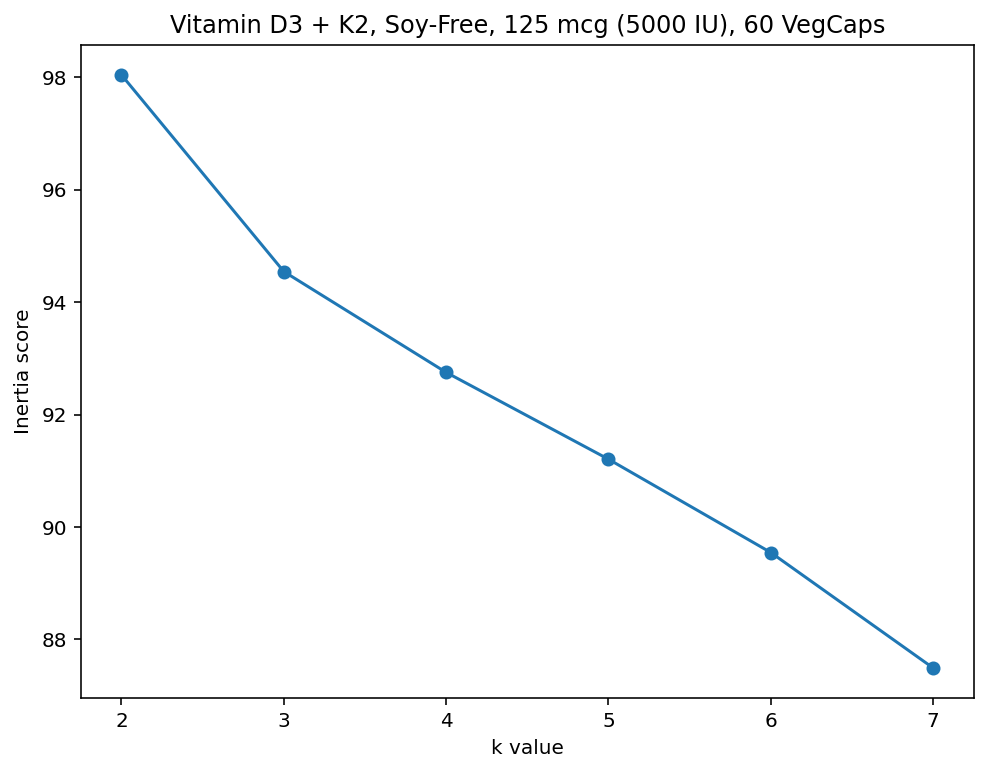

In [8]:

plt.figure()
plt.plot(kv, inertia_scores, marker='o')
plt.xlabel('k value')
plt.ylabel('Inertia score')
plt.title('Vitamin D3 + K2, Soy-Free, 125 mcg (5000 IU), 60 VegCaps')
plt.show()

Since our Inertia Score is not that high and it fluctuates in <b>a small range from 88 to 98</b>. However, we can see a gradual drop of k value from 3. On the other hand, we don't see any clear elbow shape within the range of k value, thus it doesn't give us an idea to detect the optimal k value. 

<b>There is no right number of clusters but there is an optimal one</b>.
Let's check the silhouette score and see how this different method can give us a meaninngful clue.

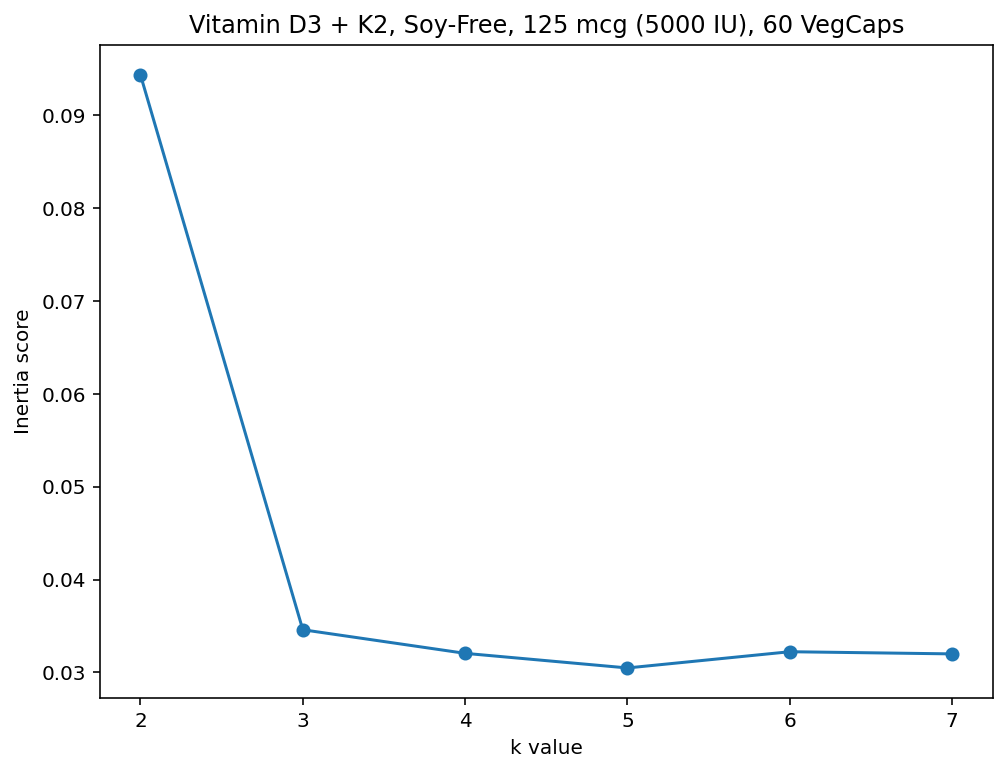

In [9]:
plt.figure()
plt.plot(kv, sil_scores, marker='o')
plt.xlabel('k value')
plt.ylabel('Inertia score')
plt.title('Vitamin D3 + K2, Soy-Free, 125 mcg (5000 IU), 60 VegCaps')
plt.show()

Since the Inertia score method used the original scoring function in the k-means algorithm, the silhouette method used the silhouette coefficient so we can expect they end up with different results.

From the above chart, we can the significant decrease from k value of 2 to 3 and then similar pattern afterward. Therefore, we could either choose the optimal value of k as 3 or 4. We could choose 4 because we might see a subtle difference between cluster 3 and 4 through the customer perspectives.

#### Let's check how the review contents look like in the different clusters:

In [10]:
def get_clusters(product_review, review_vectors, k, n):
    '''
    Function to extract n of the most representative review contents from k clusters, with density scores
    '''
    
    # Instantiate the model
    kmeans_model = KMeans(n_clusters=k, random_state=24)

    # Fit the model
    kmeans_model.fit(review_vectors);

    # Set the number of cluster centre points to look at when calculating density score
    centre_points = int(len(product_review) * 0.02)
    
    # Initialize list to store mean inner product value for each cluster
    cluster_density_scores = []
    
    # Initialize dataframe to store cluster centre sentences
    df = pd.DataFrame()

    # Loop through number of clusters
    for i in range(k):

        # Define cluster centre
        centre = kmeans_model.cluster_centers_[i]

        # Calculate inner product of cluster centre and review vectors
        inner_product_cluster = np.inner(centre, review_vectors)

        # Find the sentences with the highest inner products
        top_indices = pd.Series(inner_product_cluster).nlargest(n).index
        top_sentences = list(product_review[top_indices])
        print(f'Cluster #{i+1} reviews:\n')
        print(*top_sentences, sep='\n''\n')
        print('\n')

In [11]:
# Check 10 reviews with 4 clusters

get_clusters(product_review, review_vectors, k=4, n=5)

Cluster #1 reviews:

It first the doctor prescribed 10000 units to drink because according to the analyze it was very low. When I raised my vitamin D thanks to this particular vitamin in combination with other dietary supplement and meditations I actually got more energy. Now I drink one capsule every morning after breakfast to maintain my vitamin D.

Everyone around said that in Russia everyone especially in winter should drink vitamin D. But I decided not to believe in a word and check my level of vitamin D in the laboratory. The result was so-so though not quite critical - 38. I decided to raise D to the maximum value because it is necessary for bones hair immunity cancer prevention good mood and much more. The ordered this drug and drank it for 2 months basically drank 2 tablets a day sometimes 4 you can take such doses every day and only if you passed the tests and you know exactly what vitamin D you have where to raise. 2 month new test results showed 90. I'm happy the drug is 10

`cluster 1` : seems to come from knowledgable users who have a solid experience with the product and also got a sigficant result after using it for a particular period of time.

`cluster 2` : from the users who have realized the benefits of the product which consists of vitamin D3 and vitamin K.

`cluster 3` : is a pretty bit similar with cluster 2; However, the reviews seem like from the users who wanted to buy for their family members or themselves with the hope of improving their health condition.

`cluster 4` : contains pretty short and concise contents.

#### We may see some broken english sentences because of the automated machine translator which translated all the reviews contents from different languages to English. We have to be mindful of this issue and try to understand the context of the review contents.

In [12]:
# Check 10 reviews with 3 clusters

get_clusters(product_review, review_vectors, k=3, n=10)

Cluster #1 reviews:

It first the doctor prescribed 10000 units to drink because according to the analyze it was very low. When I raised my vitamin D thanks to this particular vitamin in combination with other dietary supplement and meditations I actually got more energy. Now I drink one capsule every morning after breakfast to maintain my vitamin D.

Everyone around said that in Russia everyone especially in winter should drink vitamin D. But I decided not to believe in a word and check my level of vitamin D in the laboratory. The result was so-so though not quite critical - 38. I decided to raise D to the maximum value because it is necessary for bones hair immunity cancer prevention good mood and much more. The ordered this drug and drank it for 2 months basically drank 2 tablets a day sometimes 4 you can take such doses every day and only if you passed the tests and you know exactly what vitamin D you have where to raise. 2 month new test results showed 90. I'm happy the drug is 10

`cluster 1` : seems to come from knowledgable users who have a solid experience with the product and also got a sigficant result after using it for a particular period of time.

`cluster 2` : contains pretty short sentences and concise idea about their experience with the supplement.

`cluster 3` : is a pretty similar with cluster 2. However, the reviews seem like from the users who wanted to buy for their family members or themselves with the hope of improving their health condition as well as a short summary about their prior research before buying the product.

#### We now have a comparision between 3 clusters and 4 clusters of the review contents. There are pretty similar ideas through the clusters since the <b>Innertia and Sihouette scores</b> are not significant between different clusters. However, we do see some subtle differences between the 4 clusters and 3 clusters.

# Experimenting the numbers of review in each cluster

Since we have <b>142 reviews</b> for the product `Vitamin D3 + K2, Soy-Free, 125 mcg (5000 IU), 60 VegCaps`, what will happen if we increase the number of review in each cluster?

In the above example, we chose 4 clusters with 10 reviews each cluster. Now we will increase the numbers of review for each cluster:

In [13]:
# Increase the number of reviews to 30:

get_clusters(product_review, review_vectors, k=4, n=30)

Cluster #1 reviews:

It first the doctor prescribed 10000 units to drink because according to the analyze it was very low. When I raised my vitamin D thanks to this particular vitamin in combination with other dietary supplement and meditations I actually got more energy. Now I drink one capsule every morning after breakfast to maintain my vitamin D.

Everyone around said that in Russia everyone especially in winter should drink vitamin D. But I decided not to believe in a word and check my level of vitamin D in the laboratory. The result was so-so though not quite critical - 38. I decided to raise D to the maximum value because it is necessary for bones hair immunity cancer prevention good mood and much more. The ordered this drug and drank it for 2 months basically drank 2 tablets a day sometimes 4 you can take such doses every day and only if you passed the tests and you know exactly what vitamin D you have where to raise. 2 month new test results showed 90. I'm happy the drug is 10

We can see there some identical reviews (we have already filtered and kept only the unique reviews for the product) as below:
- cluster 1 and cluster 2: "Everyone around said that in Russia everyone especially in winter should drink vitamin D. But I decided not to believe in a word and check my level of vitamin D in the laboratory. The result was so-so though not quite critical - 38. I decided to raise D to the maximum value because it is necessary for bones hair immunity cancer prevention good mood and much more..."
- cluster 1 and cluster 3: "Good dosage and combination of vitamin. I take 1 capsule a day during cold. The capsules are small. There are no problems with swallowing."

We need to be mindful of the fact that we don't have a lot of reviews as data points. After we indentified the cluster centres for each cluster, we also need to keep a good range for each cluster centre as the numbers of reviews which are around the cluster centre - we can call this range as the `density score`.

Firstly, we have to set the number of data point around the cluster centre as 3% of the total points which are as the total reviews in each cluster. Then we can calculate the average of the inner product between the data points and the cluster centre. This average number represents the `density score`

# Optimizing the numbers of review contents

In [14]:
def get_clusters(product_review, review_vectors, k, n):
    '''
    Function to extract n of the most representative review contents from k clusters, with density scores
    '''
    
    # Instantiate the model
    kmeans_model = KMeans(n_clusters=k, random_state=24)

    # Fit the model
    kmeans_model.fit(review_vectors);

    # Set the number of cluster centre points to look at when calculating density score
    centre_points = int(len(product_review) * 0.03)
    
    # Initialize list to store mean inner product value for each cluster
    cluster_density_scores = []
    
    # Initialize dataframe to store cluster centre sentences
    df = pd.DataFrame()

    # Loop through number of clusters
    for i in range(k):

        # Define cluster centre
        centre = kmeans_model.cluster_centers_[i]

        # Calculate inner product of cluster centre and review vectors
        inner_product_cluster = np.inner(centre, review_vectors)

        # Find the sentences with the highest inner products
        top_indices = pd.Series(inner_product_cluster).nlargest(n).index
        top_sentences = list(product_review[top_indices])
        
        centre_ips = pd.Series(inner_product_cluster).nlargest(centre_points)
        density_score = round(np.mean(centre_ips), 5)
        
        # Append the cluster density score to master list
        cluster_density_scores.append(density_score)

        # Create new row with cluster's top 10 sentences and density score
        new_row = pd.Series([top_sentences, density_score])
        
        # Append new row to master dataframe
        df = df.append(new_row, ignore_index=True)

    # Rename dataframe columns
    df.columns = ['reviews', 'density']

    # Sort dataframe by density score, from highest to lowest
    df = df.sort_values(by='density', ascending=False).reset_index(drop=True)
    
    # Loop through number of clusters selected
    for i in range(k):
        
        # Save density / similarity score & sentence list to variables
        sim_score = round(df.loc[i]["density"], 3)
        bundles = df.loc[i]['reviews'].copy()
        
        print(f'Cluster #{i+1} sentences (density score: {sim_score}):\n')
        print(*bundles, sep='\n''\n')
        print('\n')
        
    model_density_score = round(np.mean(cluster_density_scores), 5) # check the mean of the density scores through all the clusters
    
    print(f'Model density score: {model_density_score}')

In [15]:
def get_density(review_vectors, k_min=2, k_max=8):
    '''
    Function to get density scores for a range of k values
    '''

    # Set range of k values to loop through
    kv = range(k_min, k_max + 1)
    
    # Initialize list to store density scores
    density_scores = []
    
    # Set the number of points at the centre of each cluster to look at
    centre_points = int(len(review_vectors) * 0.02)

    # Loop through values of k
    for k in kv:

        # Instantiate the model
        kmeans_model = KMeans(n_clusters=k, random_state=42)

        # Fit the model
        kmeans_model.fit(review_vectors)

        # Initialize list to store mean inner product value
        mean_ipc = []

        # Loop through number of clusters
        for i in range(k):

            # Define cluster centre
            centre = kmeans_model.cluster_centers_[i]

            # Calculate inner product of cluster centre and review vectors
            inner_product_cluster = np.inner(centre, review_vectors)

            # Find the sentences with the highest inner products
            top_ipc = pd.Series(inner_product_cluster).nlargest(centre_points)

            # Append the mean inner product value to master list
            mean_ipc.append(top_ipc.mean())

        # Append the mean of the mean inner product values to density score list
        density_scores.append(np.mean(mean_ipc))
    
    return density_scores, kv

In [16]:
# Calculate density scores
density_scores, kv = get_density(review_vectors)

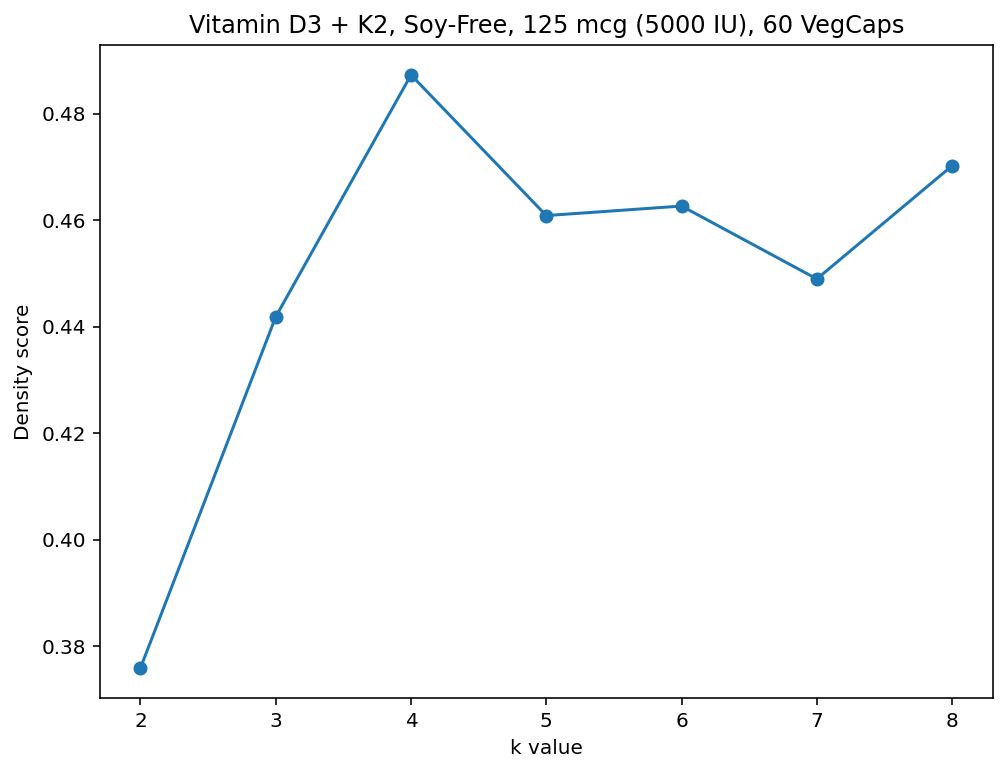

In [17]:
# Plot density scores vs. k
plt.figure()
plt.plot(kv, density_scores, marker='o')
plt.xlabel('k value')
plt.ylabel('Density score')
plt.title('Vitamin D3 + K2, Soy-Free, 125 mcg (5000 IU), 60 VegCaps')
plt.show()

This is our expectation since we have pretty similar reviews within different clusters. The graph show a gradually linear line of k value from 2 to 4 and a fluctation from 4 to 8. Thus, we may expect more of perspectives from our review contents if we raise the k value higher. However, we can see the line goes down and fluctuates from 4 as a result we don't really see any new perspectives within higher cluster numbers. One of the reasons could be a small set a review data point.

In [18]:
# Increase the number of reviews to :

get_clusters(product_review, review_vectors, k=7, n=5)

Cluster #1 sentences (density score: 0.662):

good vitamin Of regulates the absorption of calcium and Of brings them to the bones and cartilages it also affects to strengthen

Large doses of do should be taken with k to reduce side effects. Also k has such beneficial properties as sends calcium to bones and teeth; removed excess calcium from internal organs preventing the formation of calcium salts; protects against oncology by controlling the process of cell division; helps fight Atkinson's disease and rheumatoid arthritis.

The started taking supplement during menopause. His drug is a guarantee of preservation of calcium in the bones which at menopause rapidly decreases from bone tissue vitamin D stimulated metabolism and calcium is the strength of bones and teeth inhibiting the raging of joints. I think that taking a supplement I will not have osteoporosis.

Vitamin Of  Of from Solaray - regulates phosphorus-calcium metabolism ensures blood clotting strengthens bone density and cont

By skimming through the clusters, we don't really see many different themes. Especially, there are repetitive reviews between these clusters, hence we should keep the <b>k value at 4</b> and <b>numbers of review at 5</b>.

#### Let's check the density score of other products

In [19]:
# product: 'Vitamin D3 + K2, Soy-Free, 125 mcg (5000 IU), 60 VegCaps'
product_review, review_vectors, n = load_reviews('/Users/data/iherb_best_selling_products_clean_dataset.csv','Vitamin D3 + K2, Soy-Free, 125 mcg (5000 IU), 60 VegCaps')
d3_num_rev = n # total number of reviews
d3_density_scores, kv = get_density(review_vectors)

# product: 'Ester-C with Citrus Bioflavonoids, 500 mg, 225 Vegetarian Tablets'
product_review, review_vectors, n = load_reviews('/Users/data/iherb_best_selling_products_clean_dataset.csv','Ester-C with Citrus Bioflavonoids, 500 mg, 225 Vegetarian Tablets')
ec_num_rv = n  # total number of reviews
ec_density_scores, kv = get_density(review_vectors)

# product: 'Fully Active B Complex with Quatrefolic, 30 Veggie Caps'
product_review, review_vectors, n = load_reviews('/Users/data/iherb_best_selling_products_clean_dataset.csv','Fully Active B Complex with Quatrefolic, 30 Veggie Caps')
bc_num_rev = n  # total number of reviews
bc_density_score, kv = get_density(review_vectors)

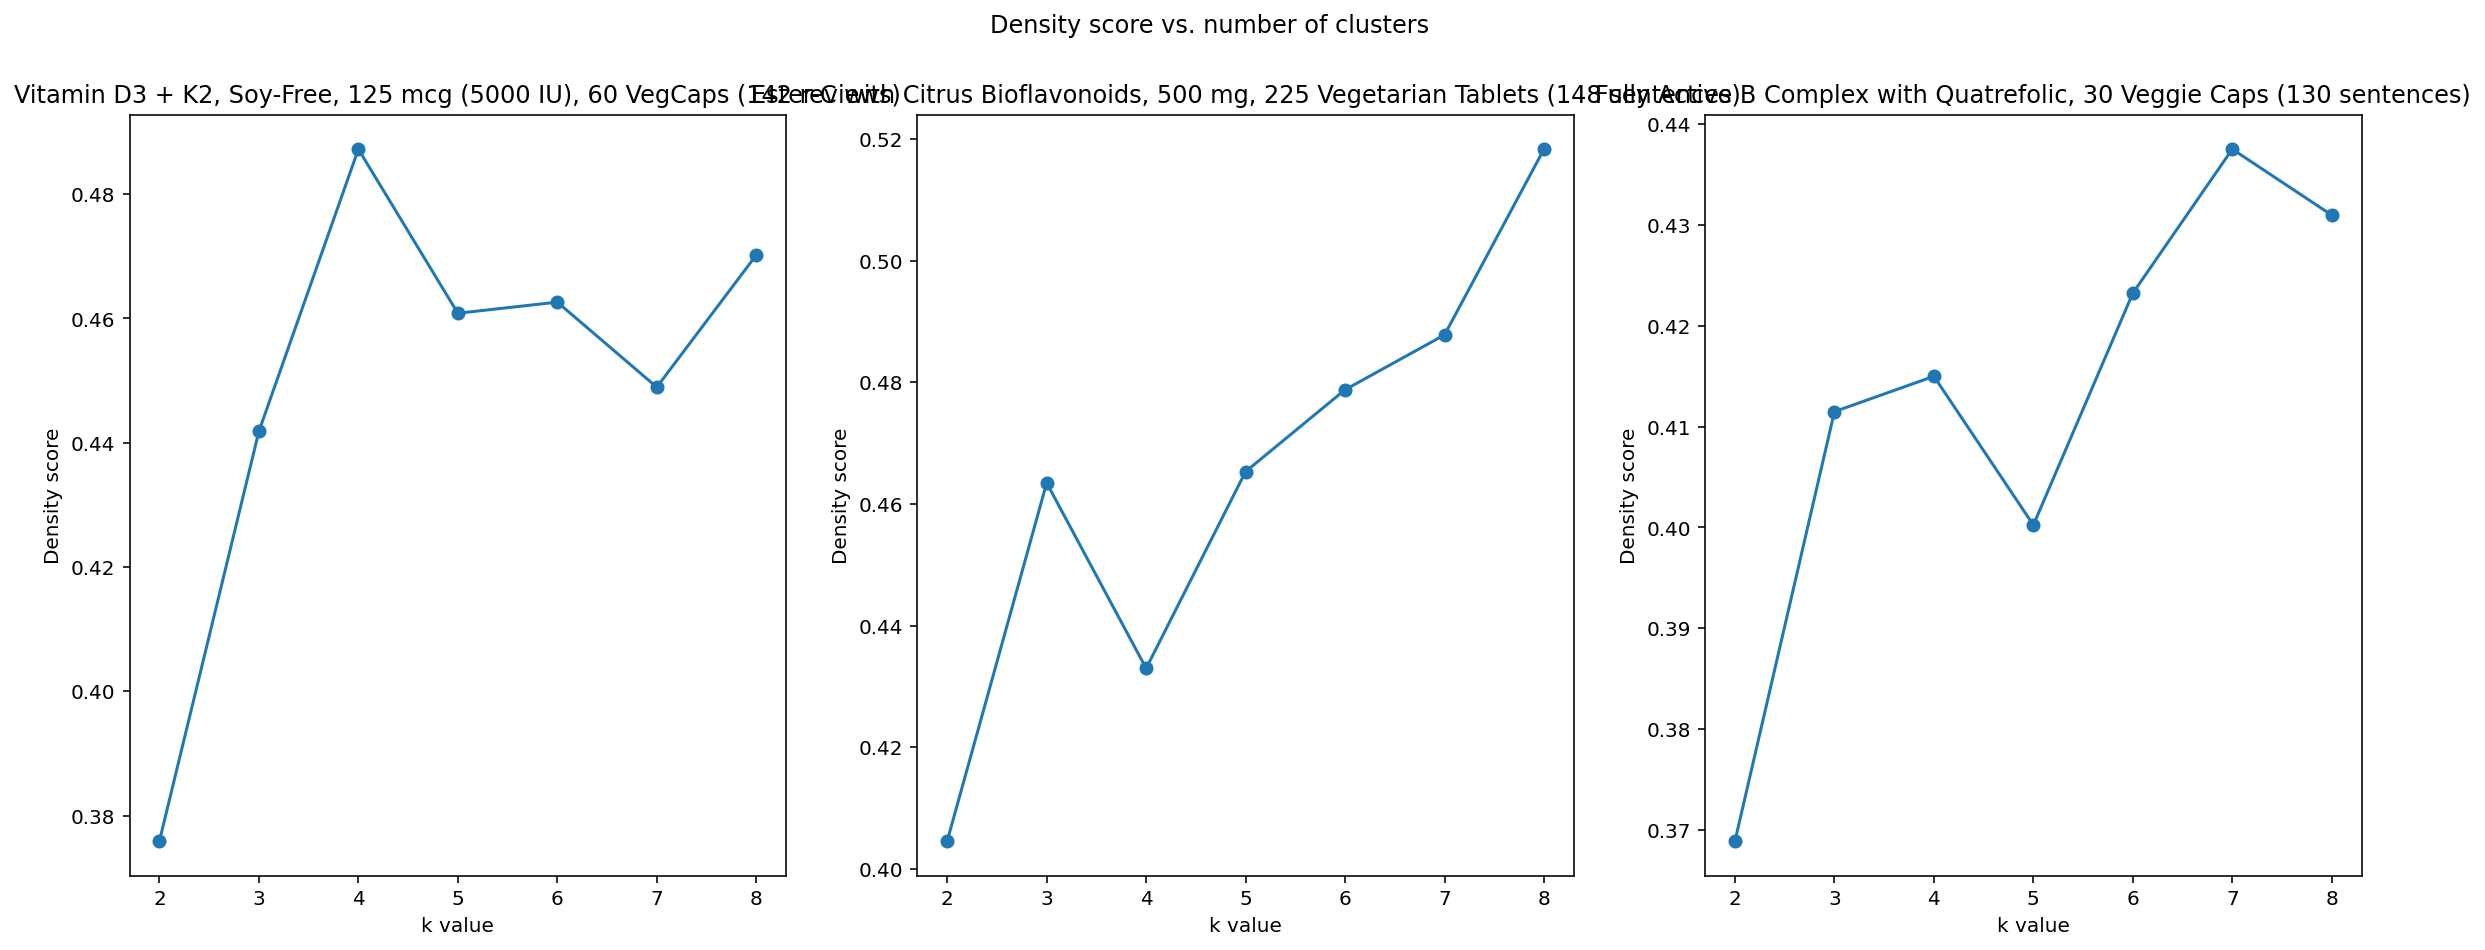

In [20]:
# Plot density scores vs. k
plt.figure(figsize=(20, 7))

plt.subplot(131)
plt.plot(kv, d3_density_scores, marker='o')
plt.xlabel('k value')
plt.ylabel('Density score')
plt.title(f'Vitamin D3 + K2, Soy-Free, 125 mcg (5000 IU), 60 VegCaps ({d3_num_rev} reviews)')

plt.subplot(132)
plt.plot(kv, ec_density_scores, marker='o')
plt.xlabel('k value')
plt.ylabel('Density score')
plt.title(f'Ester-C with Citrus Bioflavonoids, 500 mg, 225 Vegetarian Tablets ({ec_num_rv} sentences)')

plt.subplot(133)
plt.plot(kv, bc_density_score, marker='o')
plt.xlabel('k value')
plt.ylabel('Density score')
plt.title(f'Fully Active B Complex with Quatrefolic, 30 Veggie Caps ({bc_num_rev} sentences)')

plt.suptitle('Density score vs. number of clusters')

#plt.tight_layout(3,3,7)
plt.show()

We can see an interesting result here! Overall, there is a similar pattern when we increase the k value the density score is getting higher. However, we still need to keep in mind that the total reviews for each product are around 130 to 148, hence we shouldnt increase the number of cluster to 8 or we will see some identical reviews in different clusters.

There are 3 solutions:
- Keeping the number of clusters to 4 and the numbers of reviews around 10.

- Scraping more reviews per product.

- Trying DBSCAN in order to create border line for each cluster so we won't have identical reviews in different clusters.

#### CODE REFERENCES:

[github - BetterReads](https://github.com/williecostello/BetterReads/blob/master/notebooks/02_optimizing_kmeans.ipynb)